In [217]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sklearn as sk

In [218]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [219]:
device

device(type='cpu')

In [220]:
# Hyper-parameters 
input_size = 3*32*32 
num_classes = 100
num_epochs = 10
batch_size = 100
learning_rate = 0.001

In [221]:
import cifardataset

In [222]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [223]:
train_dataset = cifardataset.CIFAR100(root='./data2', 
                                           coarse=True,
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = cifardataset.CIFAR100(root='./data2', 
                                          coarse=True,
                                          train=False, 
                                          transform=transforms.ToTensor())



Files already downloaded and verified


In [224]:
train_dataset_9 = [i for i in train_dataset if i[2] == 9]
test_dataset_9 = [i for i in test_dataset if i[2] == 9]

In [225]:
#Finds categories in category 9
listCats = []

for i in range(len(train_dataset_9)):
    listCats.append(train_dataset_9[i][1])


listCats = set(listCats)
listCats

{12, 17, 37, 68, 76}

In [226]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset_9, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset_9, 
                                          batch_size=batch_size, 
                                          shuffle=False)

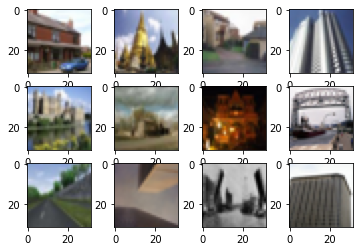

In [227]:
examples = iter(test_loader)
example_data, example_targets, example_coarse_target = examples.next()

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(example_data[i].permute(1, 2, 0)) # here we need to permute (i.e., transpose on a tensor) because imshow expects a 32*32*3 tensor, and the original one we have is 3*32*32
plt.show()


In [228]:
example_data.shape

torch.Size([100, 3, 32, 32])

In [229]:
example_targets.shape

torch.Size([100])

In [230]:
class Model(nn.Module):
    def __init__(self, input_size):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 5),
            nn.Softmax()
        )

    def forward(self, x):
        out = self.layers(x)
        return out

model = Model(input_size)


In [231]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [232]:
# Train the model
n_total_steps = len(train_loader)
listLoss = []

for epoch in range(num_epochs):
    for i, (images, labels, coarse_label) in enumerate(train_loader):  
        epochVec = []
        epochLoss = []
        images = images.reshape(-1, 3*32*32).to(device)
        labels = labels.to(device)
        labels[labels == 12] = 0
        labels[labels == 17] = 1 
        labels[labels == 37] = 2
        labels[labels == 68] = 3
        labels[labels == 76] = 4
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        epochLoss.append(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    
    epochAvg = sum(epochLoss)/len(epochLoss)
    epochVec = [(epoch+1), epochAvg]
    listLoss.append(epochVec)



C:\Users\brian\anaconda3\envs\498A\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [233]:
listLoss = np.array(listLoss)
listLoss = listLoss.transpose()
listLoss

array([[ 1.        ,  2.        ,  3.        ,  4.        ,  5.        ,
         6.        ,  7.        ,  8.        ,  9.        , 10.        ],
       [ 1.5240382 ,  1.47759628,  1.44121695,  1.43870771,  1.40213346,
         1.45137846,  1.44161332,  1.34474242,  1.39606619,  1.35550451]])

In [234]:

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels, coarse_label in test_loader:
        images = images.reshape(-1, 3*32*32).to(device)
        labels = labels.to(device)
        labels[labels == 12] = 0
        labels[labels == 17] = 1 
        labels[labels == 37] = 2
        labels[labels == 68] = 3
        labels[labels == 76] = 4
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # max returns (value ,index)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy for the 500 test images: {acc} %')

Accuracy for the 500 test images: 49.6 %


In [235]:
from sklearn import metrics
accuracy = sk.metrics.accuracy_score(labels, predicted)
precision = sk.metrics.precision_score(labels, predicted, average = None)
print("The accuracy score for the test dataset is", accuracy)
print("The precision scores for the test dataset are", precision)

The accuracy score for the test dataset is 0.55
The precision scores for the test dataset are [0.45454545 0.57142857 0.46153846 0.52       0.9       ]


Text(0.5, 1.0, 'Loss by Epoch')

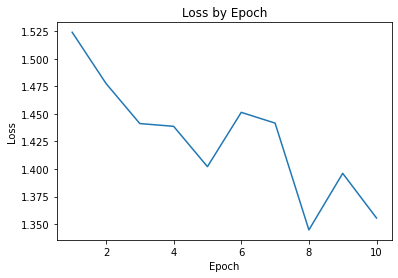

In [236]:
fig, ax = plt.subplots()
ax.plot(listLoss[0], listLoss[1])
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss by Epoch")